## Import libraries

In [60]:
import warnings
warnings.filterwarnings('ignore')

# Import functions and reload the module after making changes
from scripts import utilities
import importlib
importlib.reload(utilities)
from scripts.utilities import read_shapefile, check_transform_crs, to_geodataframe


#General libraries
import pandas as pd
import geopandas as gdp

#Plotting
import matplotlib.pyplot as plt
from ipywidgets import interact

## Basic exploration of datasets

In [2]:
path = "datasets\shp\critical_minerals.shp"
CM = read_shapefile(path)
CM=check_transform_crs(CM)
CM.head(2)

Shapefile loaded with 270 records
Columns: 21
Geometry type: ['Point']
Transforming from EPSG:3978 to EPSG:4269.


,OBJECTID,OperationG,Operatio_1,PropertyNa,Property_1,OperatorOw,Operator_1,ProvincesE,ProvincesF,Commoditie,...,Developmen,Developm_1,ActivitySt,Activity_1,Latitude,Longitude,Website,ID,EA_Status,geometry
0,1,Mine,Mine,LaRonde,LaRonde,Agnico Eagle Mines Limited,Mines Agnico Eagle Limitée,Quebec,Québec,"Gold, zinc, copper, silver, cadmium",...,Mine,Mine,Active,En activité,48.2516,-78.428,https://agnicoeagle.com,1,None,POINT (-78.42800 48.25160)
1,2,Mine,Mine,Mount Brussilof,Mount Brussilof,Baymag Inc.,Baymag Inc.,British Columbia,Colombie-Britannique,"Magnesite (fused), magnesia (products)",...,Mine,Mine,Active,En activité,50.7887,-115.683,https://baymag.com,2,None,POINT (-115.68300 50.78870)


### Admin boundaries

In [78]:
path2 = r'datasets\shp\admin_boundaries.shp'
admin = read_shapefile(path2)

Shapefile loaded with 13 records
Columns: 7
Geometry type: ['MultiPolygon' 'Polygon']


<Axes: >

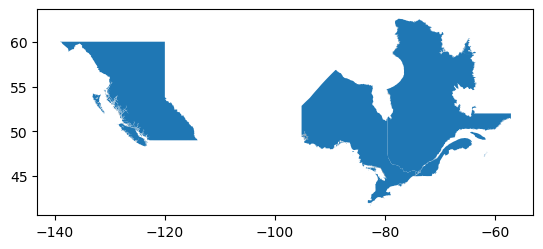

In [79]:
# target_province=admin[admin['PRENAME'].isin(['British Columbia','Nunavut','Ontario','Quebec','Yukon'])]
target_province=admin[admin['PRENAME'].isin(['British Columbia','Ontario','Quebec'])]
target_province.plot()

### Geoquem

Esperare a ver que dicen el paper sobre cual es la forma de explorar CM en sedimentos, son >65K muestras es inviable ahora.

In [34]:
# geoquem=pd.read_excel(r'datasets\rgs2020_data.xlsx')
# geoquem.head(2)

,MASTERID,ORIGINAL_REP,UPDATE_REP1,UPDATE_REP2,UPDATE_REP3,NAME,TYPE2,MAP250,MAP50,MAP20,...,W_INA_PPM,Yb_INA_PPM,Zn_INA_PPM,Zr_INA_PPM,WT_INA_g,pH,Uw_LIF_PPB,Fw_ISE_PPB,SO4_TRB_PPM,Cnd_uS/cm
0,ID082E091379,GBC 2010-13,NaN,NaN,NaN,QUEST SOUTH,STRM,082E,082E13,082E.091,...,-1.0,-2.0,NaN,220.0,44.58,7.80,NaN,19.0,NaN,17.0
1,ID082E091380,GBC 2010-13,NaN,NaN,NaN,QUEST SOUTH,STRM,082E,082E13,082E.091,...,-1.0,-2.0,NaN,-200.0,39.18,7.58,NaN,19.0,NaN,18.0


<Axes: >

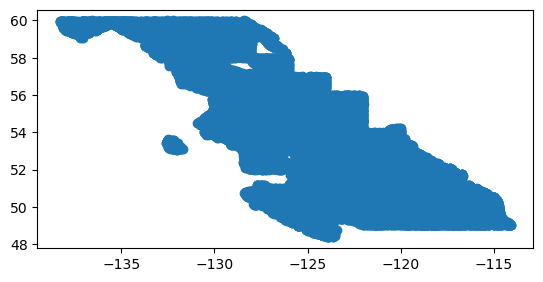

In [57]:
# ## Converting into GeoDataframe
# from shapely.geometry import Point
# geometry = [Point(xy) for xy in zip(geoquem['LONG'], geoquem['LAT'])]
# geoquem_geo = gdp.GeoDataFrame(geoquem, geometry=geometry)
# geoquem_geo.set_crs(epsg=4326, inplace=True)

#### Filtered data

In [60]:
# target_geoquem = geoquem_geo[geoquem_geo.within(target_province.unary_union)]
# # target_geoquem.plot()

## British Columbia

In [3]:
bc= read_shapefile('datasets\shp\BC_bedrock_ll83.shp')
bc=check_transform_crs(bc)

Shapefile loaded with 35424 records
Columns: 28
Geometry type: ['Polygon']
CRS is already correct.


#### Geochronology

In [71]:
new=to_geodataframe(r'datasets\BCGS_GF2020-10\BCGS_GF2020-10\new_age.csv','WGS84-lat','WGS84-long')
# NOTE: The "Sample age" field is not numeric. Six values are ranges such as "170-180".
# It might be useful to either convert these values into a numeric format or exclude them in later steps.


Error reading the file with utf-8. Trying with 'latin1' encoding...
GeoDataFrame created with 532 records
Geometry type: ['Point']
CRS=EPSG:4269


Simplyfing map by rock_class  + CM within BC province

In [4]:
bc_rocks=bc.dissolve(by='rock_class')
bc_rocks.reset_index(inplace=True) 
#Intersect CM points with BC polygons
bc_cm=gdp.sjoin(CM,bc_rocks, how='inner', op='within')

### Interactivce map

In [73]:
##Interactive map targeting CM column 
column1_values = bc_cm['Developmen'].unique()
# column2_values = bc_cm['Developmen'].unique()

@interact(column1=column1_values)
def show_map(column1):

    fig, ax = plt.subplots(figsize=(10,10))
    
    #Rock type
    bc_rocks.plot(ax=ax, column='rock_class', legend=True, cmap='viridis')
    
    #Geocronology
    new.plot(ax=ax, color ='black', marker ='o', markersize=7, alpha=0.6)
    # Adding labels for geochronology points
    # for x, y, label in zip(new.geometry.x, new.geometry.y, new['Sample Age']):
    #     ax.text(x, y, label, fontsize=8, ha='right', color='black')

    #Filtering by value for interactive map
    data_filtered = bc_cm[bc_cm['Developmen'] == column1]
    data_filtered.plot(ax=ax, color='red', marker='o', markersize=7)

    ## Adding Wicheeda point of interest
    wicheeda = bc_cm[bc_cm['Commoditie']=='Rare earth elements']
    x = wicheeda.geometry.x.iloc[0]
    y = wicheeda.geometry.y.iloc[0]
    ax.scatter(x,y, color='white', marker='o', s=50)
    ax.text(x,y,'wich', fontsize=7, ha='left', color ='white')
   

    plt.title('BC simplyfied map by rock class')
    plt.show()

interactive(children=(Dropdown(description='column1', options=('Mine', 'Smelter', 'Smelter, refinery, plant', …

In [25]:
# bc_cm['Commoditie'] = bc_cm['Commoditie'].str.strip()
bc_cm[bc_cm['Commoditie']=='Rare earth elements'].values.flatten()


array([264, 'Project', 'Projet', 'Wicheeda', 'Wicheeda',
       'Defense Metals Corp.', 'Defense Metals Corp.', 'British Columbia',
       'Colombie-Britannique', 'Rare earth elements',
       'Éléments des terres rares', 'Advanced project', 'Projet avancé',
       'Active', 'En activité', 54.53141, -122.09912,
       'https://defensemetals.com', '264', None, <POINT (-122 54.5)>, 5,
       'sedimentary rocks', 32899, '3a407beb', 26984024.0, 'DPBC',
       'Paleozoic', 'Devonian to Permian', 'Upper Devonian to Permian',
       'Big Creek Group', 'Big Creek Group',
       'Yanks Peak, Midas, Mural and Dome Creek Formations',
       'Snippaker unit',
       'mudstone, siltstone, shale fine clastic sedimentary rocks',
       'siliceous',
       'Shale, argillite, slate, calcareous argillite, limestone, tuffaceous argillite, sandstone, wacke, dacite, tuffaceous dacite; equivalent to the Earn Group',
       'Upper Devonian', 'Permian', 'Omineca', 'Cassiar',
       'Whitehorse Trough', 'Lower

In [18]:

print([f'{col}: {len(bc_cm[col].unique())}' for col in bc_cm.columns])

['OBJECTID: 44', 'OperationG: 3', 'Operatio_1: 3', 'PropertyNa: 44', 'Property_1: 44', 'OperatorOw: 34', 'Operator_1: 34', 'ProvincesE: 1', 'ProvincesF: 1', 'Commoditie: 32', 'Commodit_1: 31', 'Developmen: 5', 'Developm_1: 5', 'ActivitySt: 2', 'Activity_1: 2', 'Latitude: 44', 'Longitude: 44', 'Website: 37', 'ID: 44', 'EA_Status: 1', 'geometry: 44', 'index_right: 5', 'rock_class: 5', 'gid: 5', 'upid: 5', 'area_m2: 5', 'strat_unit: 4', 'era: 3', 'period: 4', 'strat_age: 5', 'strat_name: 4', 'gp_suite: 4', 'fm_lithodm: 5', 'mem_phase: 5', 'rock_type: 4', 'rk_char: 5', 'unit_desc: 4', 'age_max: 5', 'age_min: 5', 'belt: 2', 'terrane: 3', 'basin: 3', 'basin_age: 3', 'project: 2', 'src_url: 2', 'src_ref_s: 2', 'map_comp: 2', 'edit_date: 1', 'pub_org: 1']


In [44]:
bc_cm[bc_cm['Commoditie']=='Rare earth elements'].iloc[:, 40:]
# len(bc_cm[bc_cm['Commoditie']=='Rare earth elements'].columns)

,terrane,basin,basin_age,project,src_url,src_ref_s,map_comp,edit_date,pub_org
263,Cassiar,Whitehorse Trough,Lower Jurassic,QUEST,http://cmscontent.nrs.gov.bc.ca/geoscience/Pub...,"Logan et al., 2010, QUEST, BCGS, Geoscience Ma...","Logan et al., 2010, QUEST",2019-12-19,British Columbia Geological Survey


In [75]:
CM[CM['Commoditie']=='Rare earth elements'].iloc[:,7:18]

,ProvincesE,ProvincesF,Commoditie,Commodit_1,Developmen,Developm_1,ActivitySt,Activity_1,Latitude,Longitude,Website
144,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,46.817470,-78.474500,http://www.qpmcorp.ca
163,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,56.945830,-68.404170,https://commerceresources.com
199,Northwest Territories,Territoires du Nord-Ouest,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,62.118060,-112.599720,https://vitalmetals.com.au
214,Newfoundland and Labrador,Terre-Neuve-et-Labrador,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,52.398330,-55.824170,Not available/Pas disponible
223,Saskatchewan,Saskatchewan,Rare earth elements,Éléments des terres rares,Advanced processing project,Projet de traitement avancé,Active,En activité,52.140033,-106.627370,https://www.src.sk.ca/campaigns/rare-earth-pro...
224,Ontario,Ontario,Rare earth elements,Éléments des terres rares,Demonstration plant,Usine de démonstration,Active,En activité,44.233334,-76.500000,https://ucore.com/rapidsx/
227,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced unconventional project,Projet avancé non conventionnel,Active,En activité,45.525976,-73.340812,https://geomega.ca
230,Saskatchewan,Saskatchewan,Rare earth elements,Éléments des terres rares,Advanced processing project,Projet de traitement avancé,On hold / suspended,En attente / suspendu,52.176809,-106.656706,https://vitalmetals.com.au
232,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,48.542770,-71.154450,https://www.magrispm.com
263,British Columbia,Colombie-Britannique,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,54.531410,-122.099120,https://defensemetals.com


In [77]:
CM[(CM['Commoditie']=='Rare earth elements') & (CM['ProvincesE'].isin(['Quebec','Ontario']))]

,OBJECTID,OperationG,Operatio_1,PropertyNa,Property_1,OperatorOw,Operator_1,ProvincesE,ProvincesF,Commoditie,...,Developmen,Developm_1,ActivitySt,Activity_1,Latitude,Longitude,Website,ID,EA_Status,geometry
144,145,Project,Projet,Kipawa (Zeus),Kipawa (Zeus),Quebec Precious Metals Corporation,Corporation Métaux Précieux du Québec,Quebec,Québec,Rare earth elements,...,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,46.817470,-78.474500,http://www.qpmcorp.ca,145,None,POINT (-78.47450 46.81747)
163,164,Project,Projet,Eldor (Ashram),Eldor (Ashram),Commerce Resources Corp.,Commerce Resources Corp.,Quebec,Québec,Rare earth elements,...,Advanced project,Projet avancé,Active,En activité,56.945830,-68.404170,https://commerceresources.com,164,None,POINT (-68.40417 56.94583)
224,225,Project,Projet,RapidSX Demonstration Plant,RapidSX Demonstration Plant,Ucore Rare Metals Inc,Ucore Rare Metals Inc,Ontario,Ontario,Rare earth elements,...,Demonstration plant,Usine de démonstration,Active,En activité,44.233334,-76.500000,https://ucore.com/rapidsx/,225,None,POINT (-76.50000 44.23333)
227,228,Project,Projet,REE Recycling Facility (Saint-Bruno),Installation de recyclage d'éléments des terre,Geomega Resources Inc.,Geomega Resources Inc.,Quebec,Québec,Rare earth elements,...,Advanced unconventional project,Projet avancé non conventionnel,Active,En activité,45.525976,-73.340812,https://geomega.ca,228,None,POINT (-73.34081 45.52598)
232,233,Project,Projet,Saint-Honoré,Saint-Honoré,Magris Performance Materials Inc.,Magris Performance Materials Inc.,Quebec,Québec,Rare earth elements,...,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,48.542770,-71.154450,https://www.magrispm.com,233,None,POINT (-71.15445 48.54277)


In [82]:
palabras_clave = 'Canyon Creek'

# Crear una máscara que identifica si las palabras clave están presentes en alguna celda
mask = CM.applymap(lambda x: palabras_clave in str(x))

# Verificar si hay coincidencias en alguna parte del DataFrame
if mask.any().any():
    # Mostrar las filas donde aparecen las palabras clave
    filas_coincidentes = CM[mask.any(axis=1)]
    print(filas_coincidentes)
else:
    print("No se encontraron coincidencias con las palabras clave.")

No se encontraron coincidencias con las palabras clave.
